# Introduction

The aim of this project is to predict enrollment sizes for mathematics courses at USC. What is written here is my first foray at cleaning data and applying a model to it. It mostly serves as practice and will be updated occasionally to reflect new data and techniques that I've learned. 

In [125]:
from IPython.core.display import display,HTML
display(HTML('<style>.prompt{width: 0px; min-width: 0px; visibility: collapse}</style>'))

In [65]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

We will obtain our data from the Schedule of Classes website: https://classes.usc.edu/term-xxxxy/classes/math/

Here, the 'xxxx' is replaced with the year, and 'y' is replaced with semester: 1 for spring, 2 for summer, and 3 for fall. At the bottom of each page, there is an option to download the enrollment information in the form of a csv file. The file can be accessed through https://classes.usc.edu/term-xxxxy/csv/math.csv. It turns out that schedule of classes data is only readily available from spring of 2007 and onwards, so we will only work with this for now. 

The following code was used to download the csv files, append the year and semester on the csv (as there's no indication in the file as is), and concatenate them. The websites go down periodically, so I saved the data to 'soc_data.csv' and loaded it from that to avoid connectivity issues.

In [ ]:
separated_data = []

for year in range(2007,2020):
    for term in range(1,4):
        df = pd.read_csv('https://classes.usc.edu/term-' + str(year) + str(term) + '/csv/math.csv')
        df['Year'] = [year]*len(df.index)
        if term==1:
            df['Term'] = ['Spring']*len(df.index)
        elif term==2:
            df['Term'] = ['Summer']*len(df.index)
        else:
            df['Term'] = ['Fall']*len(df.index)
        separated_data.append(df)
        
data = pd.concat(separated_data, ignore_index = True)

In [2]:
#Did not run the above cell to avoid potential connectivity issues
data = pd.read_csv('soc_data.csv')

# Data Exploration and Cleaning

Let's take a peak at the data quickly to get an idea of what we're dealing with before splitting"

In [3]:
data.head(10)

,Course number,Course title,Registration restrictions,Units,Type,Section,Session,Time,Days,Seats,Registered,Waitlist,Instructor,Room,Year,Term
0,MATH-040x,Basic Mathematical Skills,NaN,4.0 units,Lecture,39400D,1.0,8:00-8:50am,MWF,30.0,2.0,0.0,Yong Han,KAP148,2007,Spring
1,NaN,NaN,NaN,NaN,Discussion,39401D,1.0,9:00-9:50am,"Tue, Thu",30.0,2.0,0.0,NaN,VHE206,2007,Spring
2,MATH-100o,Off-Campus Studies,NaN,"1.5-12.0 units, max 12",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2007,Spring
3,NaN,Introduction to Statistics,NaN,3.0,Lecture,05463R,93.0,TBA,TBA,50.0,1.0,0.0,NaN,TBA,2007,Spring
4,MATH-108,Precalculus,P,4.0 units,Lecture,39404D,1.0,8:00-8:50am,MWF,50.0,26.0,0.0,John Novak,KAP146,2007,Spring
5,NaN,NaN,NaN,NaN,Discussion,39405D,1.0,8:00-8:50am,"Tue, Thu",20.0,6.0,0.0,NaN,KAP141,2007,Spring
6,NaN,NaN,NaN,NaN,Discussion,39406D,1.0,9:00-9:50am,"Tue, Thu",20.0,5.0,0.0,NaN,KAP141,2007,Spring
7,NaN,NaN,NaN,NaN,Discussion,39407D,1.0,10:00-10:50am,"Tue, Thu",20.0,15.0,0.0,NaN,KAP141,2007,Spring
8,MATH-116,Mathematics for the Social Sciences,P,4.0 units,Lecture,39410D,1.0,9:00-9:50am,MWF,45.0,37.0,0.0,Attila Maroti,KAP146,2007,Spring
9,NaN,NaN,NaN,NaN,Discussion,39411D,1.0,8:00-8:50am,"Tue, Thu",15.0,10.0,0.0,NaN,GFS112,2007,Spring


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6536 entries, 0 to 6535
Data columns (total 16 columns):
Course number                1966 non-null object
Course title                 2012 non-null object
Registration restrictions    1356 non-null object
Units                        2012 non-null object
Type                         6502 non-null object
Section                      6502 non-null object
Session                      6502 non-null float64
Time                         6502 non-null object
Days                         6502 non-null object
Seats                        6502 non-null float64
Registered                   6502 non-null float64
Waitlist                     6502 non-null float64
Instructor                   2615 non-null object
Room                         6330 non-null object
Year                         6536 non-null int64
Term                         6536 non-null object
dtypes: float64(4), int64(1), object(11)
memory usage: 817.1+ KB


A few notes:

It's clear that this csv file was created for human readability. Every column has missing values (except for the two we created); each "course number"/"Course title" is recorded only once a term, leaving other sections with the same name as empty; teaching assistant names are not recorded, only the lecturer's; features that seem like they would be numeric are actually strings (e.g. course number and number of units).

The downside to this is that I needed to extract meaningful numerical data from this in order to feed it into a machine learning algorithm. As such, it's very possible that I missed possible important features or introduced unimportant ones. Nevertheless, this project main purpose is for me to practice using python's various libraries, and not necessarily to predict the enrollment with highest accuracy (though, that would be nice).

From here, I used my knowledge of math courses at USC to analyze the data. In order to look at certain subdataframes, I filled in the course numbers under the assumption that a course with no value was the same course as the most recent non-null course entry. As we can see from the snippet above, that is not necessarily true as "Introduction to Statistics" has no course number, but is preceeded by Math-100o "Off Campus Studies," so my method will assign those two the same course number. As we will see later though, I plan on dropping all of those courses from the data anyway.

Moreover, I created a new column that saved only the three digit number from the "Course number" feature. One issue with this is that there are few upper division / graduate level courses that have an a/b course. For example, there are two upper division analysis courses - 425a and 425b. Since the 'a' course will likely have more students than the 'b' course (since 'a' is a pre-req to 'b', and not every single math major program requires 'b' to graduate), I thought it would be important to record this. So I also created a "Letter" column to indicate if a course had one or not.

Since new data comes in every semester, I've created general definitions of the above operations so that I just need to call them each semester instead of re-typing the code each time.

In [5]:
def add_number_letter(dataframe):
    number_title = dataframe['Course number'].copy()
    course_number = []
    course_letter = []

    for i in range(len(number_title)):
        if not isinstance(number_title[i],str):
            number_title[i]=number_title[i-1]
        number = number_title[i].split('-')[1][:3]
        course_number.append(int(number))
        letter = number_title[i][-1]
        if letter.isdigit():
            course_letter.append('None')
        else:
            course_letter.append(letter)
    
    df = dataframe.copy()
    df['Course number'] = number_title
    df['Number'] = course_number
    df['Letter'] = course_letter
    
    return df

In [6]:
data = add_number_letter(data)

In [7]:
data.head()

,Course number,Course title,Registration restrictions,Units,Type,Section,Session,Time,Days,Seats,Registered,Waitlist,Instructor,Room,Year,Term,Number,Letter
0,MATH-040x,Basic Mathematical Skills,NaN,4.0 units,Lecture,39400D,1.0,8:00-8:50am,MWF,30.0,2.0,0.0,Yong Han,KAP148,2007,Spring,40,x
1,MATH-040x,NaN,NaN,NaN,Discussion,39401D,1.0,9:00-9:50am,"Tue, Thu",30.0,2.0,0.0,NaN,VHE206,2007,Spring,40,x
2,MATH-100o,Off-Campus Studies,NaN,"1.5-12.0 units, max 12",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2007,Spring,100,o
3,MATH-100o,Introduction to Statistics,NaN,3.0,Lecture,05463R,93.0,TBA,TBA,50.0,1.0,0.0,NaN,TBA,2007,Spring,100,o
4,MATH-108,Precalculus,P,4.0 units,Lecture,39404D,1.0,8:00-8:50am,MWF,50.0,26.0,0.0,John Novak,KAP146,2007,Spring,108,None


Before splitting it into training and test sets, I thought it would be best to take a look at types of entries for some of the other columns. There could have been some weird, unexpected entries as we'll see in a moment. 

For example, as we can see from above, the teaching assistant names are not listed in the "Instructor" column. Initially, I thoguht it would be a good idea to just drop discussion sections from the data since students only have access to the professor name, but then I realized that at least one discussion section is at a different time slot than the corresponding lecture (e.g. MWF 10-10:50am lecture, one discussion 10-10:50am TTh and the other 11-11:50am TTh), and neither of them will likely be in the same location as lecture. Thus, I thought it'd be best to fill in the discussion instructor with the professor. 

We'd run into a similar problem as course numbers though; there might be an obscure course that's not a discussion but has no instructor, like "Math-100o" above for instance. In fact, let's take a look at these "o" courses.

In [8]:
data[data['Letter']=='o']

,Course number,Course title,Registration restrictions,Units,Type,Section,Session,Time,Days,Seats,Registered,Waitlist,Instructor,Room,Year,Term,Number,Letter
2,MATH-100o,Off-Campus Studies,NaN,"1.5-12.0 units, max 12",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2007,Spring,100,o
3,MATH-100o,Introduction to Statistics,NaN,3.0,Lecture,05463R,93.0,TBA,TBA,50.0,1.0,0.0,NaN,TBA,2007,Spring,100,o
447,MATH-100o,Off-Campus Studies,NaN,"1.5-12.0 units, max 12",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2008,Spring,100,o
448,MATH-100o,Statistics,NaN,3.0,Lecture,05993R,995.0,TBA,TBA,50.0,1.0,0.0,NaN,TBA,2008,Spring,100,o
449,MATH-100o,Statistics 1000,NaN,3.0,Lecture,06037R,995.0,TBA,TBA,50.0,1.0,0.0,NaN,TBA,2008,Spring,100,o
598,MATH-300o,Off-Campus Studies,NaN,"3.5-1.5 units, max 12",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2008,Spring,300,o
599,MATH-300o,Differential Geometry,NaN,3.0,Lecture,05426R,878.0,TBA,TBA,50.0,1.0,0.0,NaN,TBA,2008,Spring,300,o
600,MATH-300o,Metric Spaces,NaN,3.0,Lecture,05427R,878.0,TBA,TBA,50.0,1.0,0.0,NaN,TBA,2008,Spring,300,o
601,MATH-300o,Pure &amp; Applied Analysis,NaN,5.0,Lecture,05428R,878.0,TBA,TBA,50.0,1.0,0.0,NaN,TBA,2008,Spring,300,o
602,MATH-300o,Algebraic Structures I,NaN,4.0,Lecture,05617R,971.0,TBA,TBA,50.0,1.0,0.0,NaN,TBA,2008,Spring,300,o


These courses have at most one registered student and no instructor, which leads me to believe that they weren't actually offered. They also were not offered from 2009 onward, so I think it's safe to say we can drop them.

In [9]:
def drop_o(dataframe):
    df = dataframe[dataframe['Letter']!='o'].copy().reset_index(drop=True)
    return df

In [10]:
data = drop_o(data)

In [11]:
data.head()

,Course number,Course title,Registration restrictions,Units,Type,Section,Session,Time,Days,Seats,Registered,Waitlist,Instructor,Room,Year,Term,Number,Letter
0,MATH-040x,Basic Mathematical Skills,NaN,4.0 units,Lecture,39400D,1.0,8:00-8:50am,MWF,30.0,2.0,0.0,Yong Han,KAP148,2007,Spring,40,x
1,MATH-040x,NaN,NaN,NaN,Discussion,39401D,1.0,9:00-9:50am,"Tue, Thu",30.0,2.0,0.0,NaN,VHE206,2007,Spring,40,x
2,MATH-108,Precalculus,P,4.0 units,Lecture,39404D,1.0,8:00-8:50am,MWF,50.0,26.0,0.0,John Novak,KAP146,2007,Spring,108,None
3,MATH-108,NaN,NaN,NaN,Discussion,39405D,1.0,8:00-8:50am,"Tue, Thu",20.0,6.0,0.0,NaN,KAP141,2007,Spring,108,None
4,MATH-108,NaN,NaN,NaN,Discussion,39406D,1.0,9:00-9:50am,"Tue, Thu",20.0,5.0,0.0,NaN,KAP141,2007,Spring,108,None


In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6524 entries, 0 to 6523
Data columns (total 18 columns):
Course number                6524 non-null object
Course title                 2000 non-null object
Registration restrictions    1356 non-null object
Units                        2000 non-null object
Type                         6494 non-null object
Section                      6494 non-null object
Session                      6494 non-null float64
Time                         6494 non-null object
Days                         6494 non-null object
Seats                        6494 non-null float64
Registered                   6494 non-null float64
Waitlist                     6494 non-null float64
Instructor                   2615 non-null object
Room                         6322 non-null object
Year                         6524 non-null int64
Term                         6524 non-null object
Number                       6524 non-null int64
Letter                       6524 non-nul

The features features from "Type" to "Waitlist" each have 30 non-null values, including time. This makes me curious as to which classes do not have a time assigned. Before we assign instructors, let's see that these are not some other obscure classes.

In [13]:
data[data['Time'].isnull()]

,Course number,Course title,Registration restrictions,Units,Type,Section,Session,Time,Days,Seats,Registered,Waitlist,Instructor,Room,Year,Term,Number,Letter
406,MATH-499,Special Topics,NaN,"2.0-4.0 units, max 8",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2007,Fall,499,None
432,MATH-599,Special Topics,NaN,"2.0-4.0 units, max 8",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2007,Fall,599,None
645,MATH-599,Special Topics,NaN,"2.0-4.0 units, max 8",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2008,Spring,599,None
668,MATH-599,Special Topics,NaN,"2.0-4.0 units, max 8",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2008,Summer,599,None
894,MATH-599,Special Topics,NaN,"2.0-4.0 units, max 8",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2008,Fall,599,None
1112,MATH-599,Special Topics,NaN,"2.0-4.0 units, max 8",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2009,Spring,599,None
1137,MATH-599,Special Topics,NaN,"2.0-4.0 units, max 8",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2009,Summer,599,None
1390,MATH-599,Special Topics,NaN,"2.0-4.0 units, max 8",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2009,Fall,599,None
1608,MATH-599,Special Topics,NaN,"2.0-4.0 units, max 8",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2010,Spring,599,None
1635,MATH-599,Special Topics,NaN,"2.0-4.0 units, max 8",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2010,Summer,599,None


In [14]:
len(data[data['Time'].isnull()].index)

30

Indeed, it looks like all 30 null times correspond to the 30 null entries in the other mentioned features. These classes were probably cancelled. Let's drop them.

In [15]:
def drop_na(dataframe):
    df = dataframe.dropna(subset=['Time'])
    df.reset_index(drop=True, inplace = True)
    return df

In [16]:
data = drop_na(data)

In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6494 entries, 0 to 6493
Data columns (total 18 columns):
Course number                6494 non-null object
Course title                 1970 non-null object
Registration restrictions    1356 non-null object
Units                        1970 non-null object
Type                         6494 non-null object
Section                      6494 non-null object
Session                      6494 non-null float64
Time                         6494 non-null object
Days                         6494 non-null object
Seats                        6494 non-null float64
Registered                   6494 non-null float64
Waitlist                     6494 non-null float64
Instructor                   2615 non-null object
Room                         6322 non-null object
Year                         6494 non-null int64
Term                         6494 non-null object
Number                       6494 non-null int64
Letter                       6494 non-nul

Things are starting to look good. A lot of the "weirdness" is going away. 

At this point, the null instructors are likely the discussion sections and research/dissertation courses (which I can confirm, having enrolled in many of the them, have no instructor listed). There's also a possibility of seminar courses having no instructor either, which happens when no one signs up for it (I know this to be true because I've enrolled in a differential equations seminar with my advisor, but the next term he said he was not offering it anymore). I don't think those courses will be important for our analysis anyway, so it should be safe to fill in the missing instructors like we did with the missing course numbers - using the most recent non-null instructor.

In [18]:
def add_instructor(dataframe):
    instructors  = dataframe['Instructor'].copy()
    
    for i in range(len(instructors)):
        if not isinstance(instructors[i],str):
            instructors[i] = instructors[i-1]
    df = dataframe.copy()
    df['Instructor'] = instructors
    
    return df

In [19]:
data = add_instructor(data)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6494 entries, 0 to 6493
Data columns (total 18 columns):
Course number                6494 non-null object
Course title                 1970 non-null object
Registration restrictions    1356 non-null object
Units                        1970 non-null object
Type                         6494 non-null object
Section                      6494 non-null object
Session                      6494 non-null float64
Time                         6494 non-null object
Days                         6494 non-null object
Seats                        6494 non-null float64
Registered                   6494 non-null float64
Waitlist                     6494 non-null float64
Instructor                   6494 non-null object
Room                         6322 non-null object
Year                         6494 non-null int64
Term                         6494 non-null object
Number                       6494 non-null int64
Letter                       6494 non-nul

Now that we've added necessary information that required a look at the data, we will now split it up into training and test sets. I'm fairly confident that if we find something weird in the training data, it can fixed without having to recall the row immediately preceding it.

In [20]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size = 0.2, random_state=14) #14 is my favorite number for some reason

In [21]:
train.head()

,Course number,Course title,Registration restrictions,Units,Type,Section,Session,Time,Days,Seats,Registered,Waitlist,Instructor,Room,Year,Term,Number,Letter
6024,MATH-126g,Calculus II,P,4.0 units,Lecture,39460D,1.0,9:00-9:50am,MWF,49.0,25.0,0.0,Felicia Tabing,GFS118,2019,Spring,126,g
4162,MATH-114xg,NaN,NaN,NaN,Discussion,39412D,1.0,11:00-11:50am,"Tue, Thu",17.0,16.0,0.0,Leonid Piterbarg,KAP166,2015,Fall,114,g
5878,MATH-229,NaN,NaN,NaN,Discussion,39584D,1.0,10:00-10:50am,"Tue, Thu",25.0,23.0,0.0,Takahiro Sakai,KAP166,2018,Fall,229,None
2088,MATH-040x,NaN,NaN,NaN,Discussion,39401D,1.0,8:00-8:50am,"Tue, Thu",20.0,9.0,0.0,Gokhan Yildirim,KAP137,2011,Fall,40,x
3684,MATH-126,NaN,NaN,NaN,Lecture,39512D,1.0,11:00-11:50am,MWF,61.0,59.0,0.0,Nathaniel Emerson,THH208,2014,Fall,126,None


In [22]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5195 entries, 6024 to 2667
Data columns (total 18 columns):
Course number                5195 non-null object
Course title                 1575 non-null object
Registration restrictions    1080 non-null object
Units                        1575 non-null object
Type                         5195 non-null object
Section                      5195 non-null object
Session                      5195 non-null float64
Time                         5195 non-null object
Days                         5195 non-null object
Seats                        5195 non-null float64
Registered                   5195 non-null float64
Waitlist                     5195 non-null float64
Instructor                   5195 non-null object
Room                         5058 non-null object
Year                         5195 non-null int64
Term                         5195 non-null object
Number                       5195 non-null int64
Letter                       5195 non-

A few observations.

The are some missing values for "Room," so we should investigate that. There are also a lot of missing values for "Units." I do know that basically every undergrad math course is 4.0 units and basically every grad course is 3.0 units. Some have a variable number of units you can take, but those are exclusively research courses, which I plan to remove as mentioned above. So this columns is likely unimportant.

Moreover, "Section" is used by the online registration system to determine which class the student has enrolled in; it's of no use to the student directly. "Session" is similar in that it dictates what part of the semester it is being held. Since all math courses run all semester long, it is irrelevant. 

Of course, "Course number" and "Course title" have been made obsolete by our "Number" and "Letter" features, so we may drop those as well.

We'll drop these columns later when we are ready to start feeding the data into algorithms.

In [23]:
train[train['Room'].isnull()]

,Course number,Course title,Registration restrictions,Units,Type,Section,Session,Time,Days,Seats,Registered,Waitlist,Instructor,Room,Year,Term,Number,Letter
1802,MATH-307,Statistical Inference and Data Analysis I,P,4.0 units,Lecture,39605D,1.0,9:00-9:50am,MWF,1.0,0.0,0.0,Larry Goldstein,NaN,2010,Fall,307,None
5575,MATH-227,NaN,NaN,NaN,Discussion,39541D,1.0,2:00-2:50pm,"Tue, Thu",20.0,0.0,0.0,Guillaume Dreyer,NaN,2018,Spring,227,None
2967,MATH-475,Introduction to Theory of Complex Variables,P,4.0 units,Lecture,39682D,1.0,9:00-9:50am,MWF,3.0,0.0,0.0,Quentin Berger,NaN,2013,Spring,475,None
1084,MATH-506,Stochastic Processes,P,3.0 units,Lecture,39710D,1.0,2:00-3:15pm,"Wed, Fri",30.0,0.0,0.0,Jin Ma,NaN,2009,Spring,506,None
4278,MATH-126,NaN,NaN,NaN,Discussion,39511D,1.0,10:00-10:50am,"Tue, Thu",17.0,0.0,0.0,Yuncheng Lin,NaN,2015,Fall,126,None
5166,MATH-577a,Computational Molecular Biology Laboratory,NaN,2.0 units,Lecture,13577D,1.0,2:00-3:50pm,Tuesday,19.0,7.0,0.0,"Remo Rohs, Liang Chen, Fei Sha</a>",NaN,2017,Spring,577,a
4328,MATH-226,NaN,NaN,NaN,Lecture,39559D,1.0,9:00-9:50am,MWF,49.0,0.0,0.0,Neelesh Tiruviluamala,NaN,2015,Fall,226,None
5429,MATH-511aL,NaN,NaN,NaN,Lecture-Lab,41057D,46.0,10:55-12:55pm,Tuesday,50.0,0.0,0.0,Meredith Franklin,NaN,2017,Fall,511,L
4232,MATH-125g,NaN,NaN,NaN,Discussion,39468D,1.0,11:00-11:50am,"Tue, Thu",16.0,0.0,0.0,Nabil Ziane,NaN,2015,Fall,125,g
4309,MATH-225,NaN,NaN,NaN,Discussion,39542D,1.0,2:00-2:50pm,"Tue, Thu",16.0,0.0,0.0,David Rose,NaN,2015,Fall,225,None


It looks like most of the null room entries are courses with no students enrolled, so were likely cancelled. Let's see which had non-zero enrollment.

In [24]:
null_rooms = train[train['Room'].isnull()]
null_rooms[null_rooms['Registered']>0]

,Course number,Course title,Registration restrictions,Units,Type,Section,Session,Time,Days,Seats,Registered,Waitlist,Instructor,Room,Year,Term,Number,Letter
5166,MATH-577a,Computational Molecular Biology Laboratory,NaN,2.0 units,Lecture,13577D,1.0,2:00-3:50pm,Tuesday,19.0,7.0,0.0,"Remo Rohs, Liang Chen, Fei Sha</a>",NaN,2017,Spring,577,a
4086,MATH-511bL,NaN,NaN,NaN,Lab,41065D,46.0,1:30-3:20pm,Friday,30.0,21.0,0.0,Wendy MacK,NaN,2015,Spring,511,L
5670,MATH-578a,Computational Molecular Biology,P,3.0 units,Lecture,39818R,1.0,11:00-12:20pm,"Tue, Thu",15.0,10.0,0.0,Andrew Smith,NaN,2018,Spring,578,a
2572,MATH-117,NaN,NaN,NaN,Discussion,39418D,1.0,12:00-12:50pm,"Tue, Thu",5.0,1.0,0.0,Leonardo Kosloff,NaN,2012,Fall,117,None
2288,MATH-511aL,Data Analysis,P,4.0 units,Lecture,41103D,46.0,1:05-3:05pm,Tuesday,90.0,55.0,0.0,William Gauderman Sandrah Eckel,NaN,2011,Fall,511,L
2289,MATH-511aL,NaN,NaN,NaN,Lab,41106D,46.0,10:55-1:00pm,Tuesday,50.0,28.0,0.0,William Gauderman Sandrah Eckel,NaN,2011,Fall,511,L
2476,MATH-445,Mathematics of Physics and Engineering II,P,4.0 units,Lecture,39661D,1.0,12:00-12:50pm,MWF,36.0,24.0,0.0,Susan Friedlander,NaN,2012,Spring,445,None
4085,MATH-511bL,NaN,NaN,NaN,Lab,41064D,46.0,8:55-10:55am,Friday,53.0,11.0,0.0,Wendy MacK,NaN,2015,Spring,511,L
2290,MATH-511aL,NaN,NaN,NaN,Lab,41108D,46.0,3:10-5:10pm,Tuesday,50.0,27.0,0.0,William Gauderman Sandrah Eckel,NaN,2011,Fall,511,L
2502,MATH-525b,Real Analysis,P,3.0 units,Lecture,39740R,1.0,9:00-9:50am,MWF,20.0,12.0,0.0,Gary Rosen,NaN,2012,Spring,525,b


The courses Math 511ab are actually NOT mathematics courses; they are crosslisted from the preventive medicine department on the Health Sciences campus, and so I doubt many undergrads/math grad students enroll in them. It should be safe to disregard those courses completely. 

Similarly, Math 577 and 578 are of service to the computational biology graduate students. I don't think they are vital to estimating more regularly offered courses, so I will disregard them as well.

As for the others, aside from the stray undergrad discussion section, they are all upper division/grad math courses. As such, I think it is safe to assume that they were held in Kap Hall (home of the math department). So we should replace those null value with "KAP."

I believe the best way to accomplish this is to drop the perviously mentioned courses, then drop all rows which have 0.0 students enrolled (as they were likely cancelled anyway), and finally assign the remaining rooms "KAP."

There's one issue with dropping rows with 0 students enrolled; sometimes in a small class, it is possible for ALL students to enroll in exactly one of the two discussion sections offered (this has not happened to me, but I have had situations with 1 or 2 students enrolled in one discussion and the rest in the other). So we will only drop 0 enrollment if the class is not a discussion. Maybe those classes were indeed cancelled, but I'd rather not take that risk. We will also assign these rooms as "Kap."

In [25]:
def remove_ls_courses(dataframe): #ls = life science
    df = dataframe.copy()
    to_drop = [511,577,578]
    for course in to_drop:
        df = df[df['Number']!=course]
    
    return df

def remove_no_students(dataframe):
    df = dataframe[dataframe['Type']!='Discussion'].copy()
    df = df[df['Registered']==0.0]
    df = dataframe.drop(df.index)
    
    return df

In [26]:
train = remove_ls_courses(train)
train = remove_no_students(train)

In [27]:
train[train['Room'].isnull()]

,Course number,Course title,Registration restrictions,Units,Type,Section,Session,Time,Days,Seats,Registered,Waitlist,Instructor,Room,Year,Term,Number,Letter
5575,MATH-227,NaN,NaN,NaN,Discussion,39541D,1.0,2:00-2:50pm,"Tue, Thu",20.0,0.0,0.0,Guillaume Dreyer,NaN,2018,Spring,227,None
4278,MATH-126,NaN,NaN,NaN,Discussion,39511D,1.0,10:00-10:50am,"Tue, Thu",17.0,0.0,0.0,Yuncheng Lin,NaN,2015,Fall,126,None
4232,MATH-125g,NaN,NaN,NaN,Discussion,39468D,1.0,11:00-11:50am,"Tue, Thu",16.0,0.0,0.0,Nabil Ziane,NaN,2015,Fall,125,g
4309,MATH-225,NaN,NaN,NaN,Discussion,39542D,1.0,2:00-2:50pm,"Tue, Thu",16.0,0.0,0.0,David Rose,NaN,2015,Fall,225,None
2258,MATH-400,NaN,NaN,NaN,Discussion,39611D,1.0,1:00-1:50pm,"Tue, Thu",2.0,0.0,0.0,Miodrag Iovanov,NaN,2011,Fall,400,None
4388,MATH-245,NaN,NaN,NaN,Discussion,39603D,1.0,8:00-8:50am,"Tue, Thu",16.0,0.0,0.0,Larry Redekopp,NaN,2015,Fall,245,None
4416,MATH-445,NaN,NaN,NaN,Discussion,39674D,1.0,11:00-11:50am,"Tue, Thu",16.0,0.0,0.0,Sergey Lototsky,NaN,2015,Fall,445,None
4258,MATH-125g,NaN,NaN,NaN,Discussion,39494D,1.0,10:00-10:50am,"Tue, Thu",17.0,0.0,0.0,Guillermo Reyes Souto,NaN,2015,Fall,125,g
4869,MATH-226,NaN,NaN,NaN,Discussion,39578D,1.0,2:00-2:50pm,"Tue, Thu",25.0,0.0,0.0,Alexander Soibelman,NaN,2016,Fall,226,None
2938,MATH-265,NaN,NaN,NaN,Discussion,39619D,1.0,3:00-3:50pm,"Tue, Thu",1.0,0.0,0.0,Cymra Haskell,NaN,2013,Spring,265,None


In [28]:
def room_to_kap(dataframe):
    df = dataframe[dataframe['Room'].isnull()].copy()
    df_og = dataframe.copy()
    df_og.loc[df.index,'Room'] = 'Kap'
    
    return df_og

In [29]:
train = room_to_kap(train)

In [30]:
train.head()

,Course number,Course title,Registration restrictions,Units,Type,Section,Session,Time,Days,Seats,Registered,Waitlist,Instructor,Room,Year,Term,Number,Letter
6024,MATH-126g,Calculus II,P,4.0 units,Lecture,39460D,1.0,9:00-9:50am,MWF,49.0,25.0,0.0,Felicia Tabing,GFS118,2019,Spring,126,g
4162,MATH-114xg,NaN,NaN,NaN,Discussion,39412D,1.0,11:00-11:50am,"Tue, Thu",17.0,16.0,0.0,Leonid Piterbarg,KAP166,2015,Fall,114,g
5878,MATH-229,NaN,NaN,NaN,Discussion,39584D,1.0,10:00-10:50am,"Tue, Thu",25.0,23.0,0.0,Takahiro Sakai,KAP166,2018,Fall,229,None
2088,MATH-040x,NaN,NaN,NaN,Discussion,39401D,1.0,8:00-8:50am,"Tue, Thu",20.0,9.0,0.0,Gokhan Yildirim,KAP137,2011,Fall,40,x
3684,MATH-126,NaN,NaN,NaN,Lecture,39512D,1.0,11:00-11:50am,MWF,61.0,59.0,0.0,Nathaniel Emerson,THH208,2014,Fall,126,None


Next step is to retrieve numerical data from Time and Days. I decided to extract the start and end times as well as the length of time from the 'Time' feature, and the number of days a week that the class meets.

In [31]:
train['Time'].unique()

array(['9:00-9:50am', '11:00-11:50am', '10:00-10:50am', '8:00-8:50am',
       '1:00-1:50pm', '3:00-3:50pm', '4:00-4:50pm', '2:00-2:50pm',
       '12:00-12:50pm', 'TBA', '2:00-3:15pm', '2:00-3:50pm',
       '10:30-12:20pm', '11:00-12:50pm', '2:00-3:20pm', '3:00-4:30pm',
       '6:00-7:50pm', '1:00-2:50pm', '9:00-10:50am', '3:30-4:30pm',
       '9:00-11:45am', '5:30-6:45pm', '4:30-6:45pm', '8:30-9:50am',
       '12:00-1:50pm', '10:00-11:50am', '9:30-12:30pm', '11:00-2:00pm',
       '4:45-6:00pm', '11:00-2:30pm', '4:00-6:50pm', '12:00-2:00pm',
       '3:30-4:50pm', '1:30-3:20pm', '1:30-3:30pm', '5:00-6:40pm',
       '8:30-9:45am', '8:40-9:55am', '12:30-1:50pm', '12:30-1:45pm',
       '1:00-2:15pm', '4:40-5:55pm', '2:55-4:25pm', '7:30-8:50am',
       '12:00-1:15pm', '6:30-8:30pm', '9:00-11:50am', '4:00-5:15pm',
       '4:00-5:45pm', '10:00-12:50pm', '4:30-5:50pm', '5:00-7:00pm',
       '11:00-1:45pm', '6:00-8:00pm', '11:30-12:50pm', '11:00-1:20pm',
       '1:00-3:00pm', '12:00-1:20pm', '10

Notice that every time is structured the same way, minus the 'TBA' time which we will investigate shortly. It's of the form 
start time - end time, and the am and pm reflect the end time's time of day. For example, 11:00-1:45pm as opposed to 11:00am-1:45pm. Before we write the functions to handle this, let's see what's going on with 'TBA.'

In [32]:
train[train['Time']=='TBA']

,Course number,Course title,Registration restrictions,Units,Type,Section,Session,Time,Days,Seats,Registered,Waitlist,Instructor,Room,Year,Term,Number,Letter
5703,MATH-590,NaN,NaN,NaN,Lecture,39461D,59.0,TBA,TBA,20.0,2.0,0.0,Eric Friedlander,OFFICE,2018,Summer,590,None
5969,MATH-710,Seminar in Algebra,NaN,3.0 units,Lecture,39807R,1.0,TBA,TBA,10.0,1.0,0.0,Eric Friedlander,OFFICE,2018,Fall,710,None
3533,MATH-794d,Doctoral Dissertation,P,2.0 units,Lecture,39964D,1.0,TBA,TBA,10.0,5.0,0.0,Francis Bonahon,OFFICE,2014,Spring,794,d
5172,MATH-594z,Master's Thesis,PC,0.0 units,Lecture,39940R,1.0,TBA,TBA,10.0,1.0,0.0,Andrew Smith,OFFICE,2017,Spring,594,z
5211,MATH-794c,Doctoral Dissertation,P,2.0 units,Lecture,39506D,54.0,TBA,TBA,20.0,1.0,0.0,Guillermo Reyes Souto,OFFICE,2017,Summer,794,c
1572,MATH-500,Graduate Colloquium,NaN,2.0 units,Lecture,39692R,1.0,TBA,TBA,30.0,11.0,0.0,Jason Fulman,OFFICE,2010,Spring,500,None
1604,MATH-705,Seminar in Probability,NaN,3.0 units,Lecture,39944R,1.0,TBA,TBA,10.0,9.0,0.0,Sergey Lototsky,OFFICE,2010,Spring,705,None
3290,MATH-740,Seminar in Topology,NaN,3.0 units,Lecture,39809R,1.0,TBA,TBA,12.0,10.0,0.0,Ko Honda,OFFICE,2013,Fall,740,None
4685,MATH-740,Seminar in Topology,NaN,3.0 units,Lecture,39951R,1.0,TBA,TBA,10.0,2.0,0.0,Francis Bonahon,OFFICE,2016,Spring,740,None
2308,MATH-610,Topics in Algebra,NaN,"3.0 units, max 12",Lecture,39795R,1.0,TBA,TBA,20.0,8.0,0.0,Susan Montgomery,TBA,2011,Fall,610,None


It looks like all of the Research related courses have a 'TBA' time and days (for the most part).

In [33]:
train[train['Time']=='TBA']['Number'].value_counts()

794    141
594     67
590     38
790     30
490     24
512     19
725     16
710     12
740     11
705     11
500     10
625      8
599      7
610      7
395      6
605      5
501      5
630      3
596      3
655      3
606      2
735      2
601      2
390      2
595      2
466      2
570      2
665      1
681      1
410      1
585      1
580      1
Name: Number, dtype: int64

Indeed, as it looks like the vast majority of the courses are research related, it might be better to just drop these from our data. In particular, there are no lower division courses on the above list, and moreover only 3 non-research related undergrad courses (1 410 section and 2 466 sections). I suspect that removing these will simultaneously get rid of all of our research courses which was the plan from the start.

In [34]:
same = []
tba_courses = train[train['Time']=='TBA']['Number'].value_counts()
number_values = train['Number'].value_counts()

for val in tba_courses.index:
    if tba_courses[val] == number_values[val]:
        same.append(val)
        
same

[794, 594, 590, 790, 490, 740, 596, 735, 390, 665, 585]

Excellent. The main research courses in the department are 490, 590, 790, and 794. According to the above output, all of those courses have a TBA time. However, only two seminar courses are captured (735 and 740). We can delete the other ones manually since there aren't too many anyway.

In [35]:
def drop_tba(dataframe):
    df = dataframe[dataframe['Time']!='TBA'].copy()
    return df

In [36]:
train = drop_tba(train)

In [37]:
train[train['Days']=='TBA']

,Course number,Course title,Registration restrictions,Units,Type,Section,Session,Time,Days,Seats,Registered,Waitlist,Instructor,Room,Year,Term,Number,Letter


It looks like this also took care of days with 'TBA' entries as well. We now right our time and day functions, noting that the number of capital letters in the 'Days' entry tells us how many days a week that class meets.

In [38]:
def length_start_end(time):
    start_end = time.split('-')
    start_str = start_end[0].split(':') #Gives [hour,minutes]
    end_str = start_end[1].split(':') #Gives [hour, minutes_xm]
    start_int = [int(start_str[0]),int(start_str[1])]
    end_int = [int(end_str[0]),int(end_str[1][:2])] #Drops 'xm'
    start_time = start_int[0] + (start_int[1]/60)    
    end_time = end_int[0] + (end_int[1]/60)    
    length = end_time - start_time
    if length<0: #Accounts for classes starting in am and ending in pm
        length+=12
    return [length,start_time,end_time]

In [39]:
def num_of_cap(text):
    return sum(1 for cap in text if cap.isupper())

In [40]:
def create_time_days(dataframe):
    df = dataframe.copy()
    times = df['Time'].tolist()
    days = df['Days'].tolist()
    class_length = [length_start_end(time)[0] for time in times]
    stime = [length_start_end(time)[1] for time in times]
    etime = [length_start_end(time)[2] for time in times]
    days_per_week = [num_of_cap(day) for day in days]
    df['days_per_week'] = days_per_week
    df['stime'] = stime
    df['etime'] = etime
    df['class_length'] = class_length
    return df

In [41]:
train = create_time_days(train)

In [42]:
train.head()

,Course number,Course title,Registration restrictions,Units,Type,Section,Session,Time,Days,Seats,...,Instructor,Room,Year,Term,Number,Letter,days_per_week,stime,etime,class_length
6024,MATH-126g,Calculus II,P,4.0 units,Lecture,39460D,1.0,9:00-9:50am,MWF,49.0,...,Felicia Tabing,GFS118,2019,Spring,126,g,3,9.0,9.833333,0.833333
4162,MATH-114xg,NaN,NaN,NaN,Discussion,39412D,1.0,11:00-11:50am,"Tue, Thu",17.0,...,Leonid Piterbarg,KAP166,2015,Fall,114,g,2,11.0,11.833333,0.833333
5878,MATH-229,NaN,NaN,NaN,Discussion,39584D,1.0,10:00-10:50am,"Tue, Thu",25.0,...,Takahiro Sakai,KAP166,2018,Fall,229,None,2,10.0,10.833333,0.833333
2088,MATH-040x,NaN,NaN,NaN,Discussion,39401D,1.0,8:00-8:50am,"Tue, Thu",20.0,...,Gokhan Yildirim,KAP137,2011,Fall,40,x,2,8.0,8.833333,0.833333
3684,MATH-126,NaN,NaN,NaN,Lecture,39512D,1.0,11:00-11:50am,MWF,61.0,...,Nathaniel Emerson,THH208,2014,Fall,126,None,3,11.0,11.833333,0.833333


Since choices are limited in a given term and some majors have strict requirements on when they need to complete certain courses, I felt like professor information might be slightly irrelevant in favor of class time. Nevertheless, I thought it might be fun to insert Rate My Professor scores into the data. Unfortunately, it is against the Terms of Use of ratemyprofessors.com to scrape their website, and moreover, a lot of the short term professors (e.g. post-docs) might not even have entries on there. So to avoid the headache of writing a scraper, I decided to look up the current professors (which you can find on the USC Math Department website) and create dictionary with their scores and then impute the remaining values.

Before that though, there are a few problems with the Instructor column.

In [43]:
train['Instructor'].unique()

array(['Felicia Tabing', 'Leonid Piterbarg', 'Takahiro Sakai',
       'Gokhan Yildirim', 'Nathaniel Emerson', 'Guillermo Reyes Souto',
       'Ricardo Mancera', 'Doyoon Kim', 'Charles Lanski',
       'Remigijus Mikulevicius', 'Richard Arratia', 'Jason Fulman',
       'Jesse Levitt', 'Guillaume Dreyer', 'Neelesh Tiruviluamala',
       'Alona Kryshchenko', 'Sheldon Kamienny', 'Sandra Daoust',
       'David Crombecque', 'Jin Ma', 'Mircea Voineagu', 'Peter Baxendale',
       'Alan Schumitzky', 'Brian Ryals', 'Amjad Tuffaha', 'Juhi Jang',
       'Qingshuo Song', 'Fernando Ordonez', 'Florence Lin',
       'Oleksandr Lytvak', 'Paul Tokorcheck', 'Gary Rosen',
       'Sergey Lototsky', 'Miguel Dumett', 'Cindy Blois',
       'Wlodek Proskurowski', 'Marc Hoyois', 'Jacob Rooney',
       'Chunming Wang', 'Konstantin Zuev', 'Qingtao Chen', 'Ko Honda',
       'Harun Aydilek', 'Susan Montgomery', 'Robert Guralnick',
       'Satwindar Sadhal', 'Gene Kim', 'Larry Redekopp', 'Cymra Haskell',
       'Robe

As we can see, some courses have multiple professors (and weirdly enough, they're not always separated by a column). My solution to this was to just extract the first (full) name given in the list. Another thing to note is that 'Arnold Deal' and 'Amy Yung' work in the math office; their names are only used if a professor hasn't been assigned. But as we can see, even after one is added, their names are mistakenly leftover. So we must get rid of those as well.

In [44]:
train[train['Instructor'].str.contains('Arnold Deal')]['Instructor'].unique()

array(['Robert Sacker Arnold Deal Ricardo Mancera',
       'Richard Arratia, Arnold Deal', 'Leonid Piterbarg, Arnold Deal',
       'Chunming Wang, Arnold Deal', 'Robert Guralnick, Arnold Deal'],
      dtype=object)

In [45]:
train[train['Instructor'].str.contains('Amy Yung')]['Instructor'].unique()

array([], dtype=object)

Thankfully, 'Arnold Deal' never shows up by himself and is never the first name. It turns out all of the Amy courses were already removed, but I can confirm that her appearances were analogous to Arnold's.

In [46]:
def one_prof(name):
    nospace = name.split(' ')
    return (nospace[0]+" "+nospace[1]).replace(',','')

Now, we create our RMP dictionary and create the appropriate column.

In [47]:
professor_dict = {'Ken Alexander' : 3.4,
'Kenneth Alexander' : 3.4,
'Richard Arratia' : 2.5,
'Aravind Asok' : 2.42,
'Sami Assaf' : 3.8,
'Jay Bartroff' : 4.3,
'Peter Baxendale' : 3.7,
'Francis Bonahon' : 4.4,
'Nathaniel Bottman' : 5.0,
'David Crombecque' : 4.0,
'Yu Deng' : 1.9,
'Guillaume Dreyer' : 2.94,
'Nathaniel Emerson' : 3.5,
'Qi Feng' : 2.5,
'Susan Friedlander' : 3.0,
'Jason Fulman' : 2.44,
'Sheel Ganatra' : 5.0,
'Yuan Gao' : 1.2,
'Larry Goldstein' : 2.5,
'Robert Guralnick' : 1.9,
'Michael Hall' : 4.2,
'Cymra Haskell' : 2.3,
'Nicolai Haydn' : 2.8,
'Steven Heilman' : 3.6,
'Juhi Jang' : 5.0,
'Sheldon Kamienny' : 2.5,
'Aaron Lauda' : 4.4,
'Jesse Levitt' : 2.4,
'Sergey Lototsky' : 3.0,
'Jin Ma' : 4.0,
'Fedor Malikov' : 2.63,
'Ricardo Mancera' : 2.9,
'Andrew Manion' : 4.5,
'Aaron Mazel-Gee' : 3.5,
'Remigijus Mikulevicius' : 4.06,
'Stanislav Minsker' : 1.0,
'Susan Montgomery' : 2.36,
'Mohamed Ndaoud' : 4.3,
'Wojciech Ozanski' : 3.5,
'Brendan Pawlowski' : 2.4,
'Guillermo Reyes' : 3.8,
'Gary Rosen' : 3.5,
'Robert Sacker' : 2.3,
'Qingtang Su' : 2.0,
'Felicia Tabing' : 2.1,
'Jonathan Taylor' : 1.3,
'Neelesh Tiruviluamala' : 4.7,
'Paul Tokorcheck' : 3.1,
'Chunming Wang' : 1.6,
'Haitian Yue' : 2.8,
'Jianfeng Zhang' : 3.28,
'Nabil Ziane' : 3.0,
'Mohammed Ziane' : 3.0,
'Charles Lanski' : 1.72,
'Alan Schumitzky' : 2.67,
'Wlodek Proskurowski' : 2.75,
'Ting-Kam Wong' : 2.0,
'Christian Zillinger' : 2.0
}

In [48]:
def create_RMP(dataframe,dict_):
    df = dataframe.copy()
    profs = [one_prof(name) for name in df['Instructor'].tolist()]
    df['prof_name'] = profs
    df['RMP_score'] = df['prof_name'].map(dict_)
    df.drop(columns=['prof_name'],inplace=True)
    return df

In [49]:
train = create_RMP(train,professor_dict)

The last piece of information I would like to extract is geographic location. I don't think this matters much, but again I thought it'd be fun. Maybe students don't like certain buildings, or perhaps they have a class right after math that's across campus. There aren't too many buildings, so I also manually created a dictionary like the RMP Scores. Any potential 'Office' rooms are assumed to be 'KAP.'

In [50]:
lat_dict = {'VPD':34.0189457,'OHE':34.0206254,'OFF':34.0206254,'KAP':34.0206254,'MHP':34.0186789,'GFS':34.0213012,'SSL':34.0196113,'ACB':34.019611,'HED':34.0201006,'KDC':34.0234685,'THH':34.02285,'SSB':34.0666261,'DRB':34.0214331,'SLH':34.0195725,'VKC':34.0212585,'CHP':34.0630034,'SOS':34.0215692,'ZHS':34.0192508,'LVL':34.021853,'RRI':34.0222018,'RTH':34.0201366,'MCB':34.0217334,'WPH':34.0219251,'VHE':34.0201249,'SGM':34.020052}

long_dict = {'VPD':-118.2860472,'OHE':-118.2918824,'OFF':-118.2918824,'KAP':-118.2918824,'MHP':-118.2888287,'GFS':-118.2902415,'SSL':-118.2909881,'ACB':-118.2975542,'HED':-118.2914612,'KDC':-118.2873925,'THH':-118.2870715,'SSB':-118.1996586,'DRB':-118.2933334,'SLH':-118.2897702,'VKC':-118.2861912,'CHP':-118.2061006,'SOS':-118.2859407,'ZHS':-118.2885132,'LVL':-118.285136,'RRI':-118.2923362,'RTH':-118.2921144,'MCB':-118.2917151,'WPH':-118.2861156,'VHE':-118.2904102,'SGM':-118.2898983}

In [51]:
def geographic_info(dataframe, lat, long):
    df = dataframe.copy()
    rooms = df.dropna(subset=['Room'])['Room']
    building = [room[:3] for room in rooms.tolist()]
    df.loc[rooms.index,'BuildingCode'] = building
    df['Latitude'] = df['BuildingCode'].map(lat)
    df['Longitude'] = df['BuildingCode'].map(long)
    df.drop(columns = ['BuildingCode'],inplace=True)
    return df

In [52]:
train = geographic_info(train,lat_dict,long_dict)
train.head()

,Course number,Course title,Registration restrictions,Units,Type,Section,Session,Time,Days,Seats,...,Term,Number,Letter,days_per_week,stime,etime,class_length,RMP_score,Latitude,Longitude
6024,MATH-126g,Calculus II,P,4.0 units,Lecture,39460D,1.0,9:00-9:50am,MWF,49.0,...,Spring,126,g,3,9.0,9.833333,0.833333,2.1,34.021301,-118.290241
4162,MATH-114xg,NaN,NaN,NaN,Discussion,39412D,1.0,11:00-11:50am,"Tue, Thu",17.0,...,Fall,114,g,2,11.0,11.833333,0.833333,NaN,34.020625,-118.291882
5878,MATH-229,NaN,NaN,NaN,Discussion,39584D,1.0,10:00-10:50am,"Tue, Thu",25.0,...,Fall,229,None,2,10.0,10.833333,0.833333,NaN,34.020625,-118.291882
2088,MATH-040x,NaN,NaN,NaN,Discussion,39401D,1.0,8:00-8:50am,"Tue, Thu",20.0,...,Fall,40,x,2,8.0,8.833333,0.833333,NaN,34.020625,-118.291882
3684,MATH-126,NaN,NaN,NaN,Lecture,39512D,1.0,11:00-11:50am,MWF,61.0,...,Fall,126,None,3,11.0,11.833333,0.833333,3.5,34.022850,-118.287071


In [53]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4430 entries, 6024 to 2667
Data columns (total 25 columns):
Course number                4430 non-null object
Course title                 964 non-null object
Registration restrictions    748 non-null object
Units                        964 non-null object
Type                         4430 non-null object
Section                      4430 non-null object
Session                      4430 non-null float64
Time                         4430 non-null object
Days                         4430 non-null object
Seats                        4430 non-null float64
Registered                   4430 non-null float64
Waitlist                     4430 non-null float64
Instructor                   4430 non-null object
Room                         4430 non-null object
Year                         4430 non-null int64
Term                         4430 non-null object
Number                       4430 non-null int64
Letter                       4430 non-nul

We're just about done cleaning the data. We'll now take the time to drop the unnecessary columns. These are:
Course number, course title, Registration restrictions, Units, Section, Session, Time, Days, Waitlist, Instructor, and Room.

In [54]:
def drop_unnecessary_columns(dataframe):
    df = dataframe.copy()
    un_cols = ['Course number', 'Course title', 'Registration restrictions', 'Units', 'Section', 'Session', 'Time',
              'Days', 'Waitlist', 'Instructor', 'Room']
    df.drop(columns=un_cols,inplace=True)
    return df

In [55]:
train = drop_unnecessary_columns(train)
train.head()

,Type,Seats,Registered,Year,Term,Number,Letter,days_per_week,stime,etime,class_length,RMP_score,Latitude,Longitude
6024,Lecture,49.0,25.0,2019,Spring,126,g,3,9.0,9.833333,0.833333,2.1,34.021301,-118.290241
4162,Discussion,17.0,16.0,2015,Fall,114,g,2,11.0,11.833333,0.833333,NaN,34.020625,-118.291882
5878,Discussion,25.0,23.0,2018,Fall,229,None,2,10.0,10.833333,0.833333,NaN,34.020625,-118.291882
2088,Discussion,20.0,9.0,2011,Fall,40,x,2,8.0,8.833333,0.833333,NaN,34.020625,-118.291882
3684,Lecture,61.0,59.0,2014,Fall,126,None,3,11.0,11.833333,0.833333,3.5,34.022850,-118.287071


Now that we have a better look, we need to create dummy variables for Type, Term, and Letter. This probably isn't good practice, but I'm also going to drop the corresponding categorical columns.

In [56]:
def create_dummies(dataframe,column):
    dummies = pd.get_dummies(dataframe[column],prefix=column)
    df = pd.concat([dataframe,dummies],axis=1)
    df.drop(columns=column,inplace=True)
    return df

In [57]:
cat_col = ['Type','Term','Letter']
for column in cat_col:
    train = create_dummies(train,column)
train.head()

,Seats,Registered,Year,Number,days_per_week,stime,etime,class_length,RMP_score,Latitude,...,Type_Lecture-Lab,Term_Fall,Term_Spring,Term_Summer,Letter_L,Letter_None,Letter_a,Letter_b,Letter_g,Letter_x
6024,49.0,25.0,2019,126,3,9.0,9.833333,0.833333,2.1,34.021301,...,0,0,1,0,0,0,0,0,1,0
4162,17.0,16.0,2015,114,2,11.0,11.833333,0.833333,NaN,34.020625,...,0,1,0,0,0,0,0,0,1,0
5878,25.0,23.0,2018,229,2,10.0,10.833333,0.833333,NaN,34.020625,...,0,1,0,0,0,1,0,0,0,0
2088,20.0,9.0,2011,40,2,8.0,8.833333,0.833333,NaN,34.020625,...,0,1,0,0,0,0,0,0,0,1
3684,61.0,59.0,2014,126,3,11.0,11.833333,0.833333,3.5,34.022850,...,0,1,0,0,0,1,0,0,0,0


In [58]:
train.columns

Index(['Seats', 'Registered', 'Year', 'Number', 'days_per_week', 'stime',
       'etime', 'class_length', 'RMP_score', 'Latitude', 'Longitude',
       'Type_Discussion', 'Type_Lecture', 'Type_Lecture-Discussion',
       'Type_Lecture-Lab', 'Term_Fall', 'Term_Spring', 'Term_Summer',
       'Letter_L', 'Letter_None', 'Letter_a', 'Letter_b', 'Letter_g',
       'Letter_x'],
      dtype='object')

Finally, we impute the missing information. We'll use a median strategy. Note that a lot of data is missing for RMP, so I imagine this column will probably not be too helpful.

In [59]:
def impute_missing(dataframe):
    df = dataframe.copy()
    df['RMP_score'] = df['RMP_score'].fillna(df['RMP_score'].mean())
    df['Latitude'] = df['Latitude'].fillna(df['Latitude'].mean())
    df['Longitude'] = df['Longitude'].fillna(df['Longitude'].mean())
    return df

In [60]:
train = impute_missing(train)

In [61]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4430 entries, 6024 to 2667
Data columns (total 24 columns):
Seats                      4430 non-null float64
Registered                 4430 non-null float64
Year                       4430 non-null int64
Number                     4430 non-null int64
days_per_week              4430 non-null int64
stime                      4430 non-null float64
etime                      4430 non-null float64
class_length               4430 non-null float64
RMP_score                  4430 non-null float64
Latitude                   4430 non-null float64
Longitude                  4430 non-null float64
Type_Discussion            4430 non-null uint8
Type_Lecture               4430 non-null uint8
Type_Lecture-Discussion    4430 non-null uint8
Type_Lecture-Lab           4430 non-null uint8
Term_Fall                  4430 non-null uint8
Term_Spring                4430 non-null uint8
Term_Summer                4430 non-null uint8
Letter_L                   4

Since we need to add all of these columns to our test data, let's create a function that encapsulates all of the operations we did above.

In [115]:
def prepare_data(dataframe):
    df = remove_ls_courses(dataframe)
    df = remove_no_students(df)
    df = room_to_kap(df)
    df = drop_tba(df)
    df = create_time_days(df)
    df = create_RMP(df,professor_dict)
    df = geographic_info(df,lat_dict,long_dict)
    df = drop_unnecessary_columns(df)
    for column in cat_col:
        df= create_dummies(df,column)
    df = impute_missing(df)
    return df

# Modeling

We are now ready to prepare our models for prediction.

In [69]:
corr_matrix = train.corr()

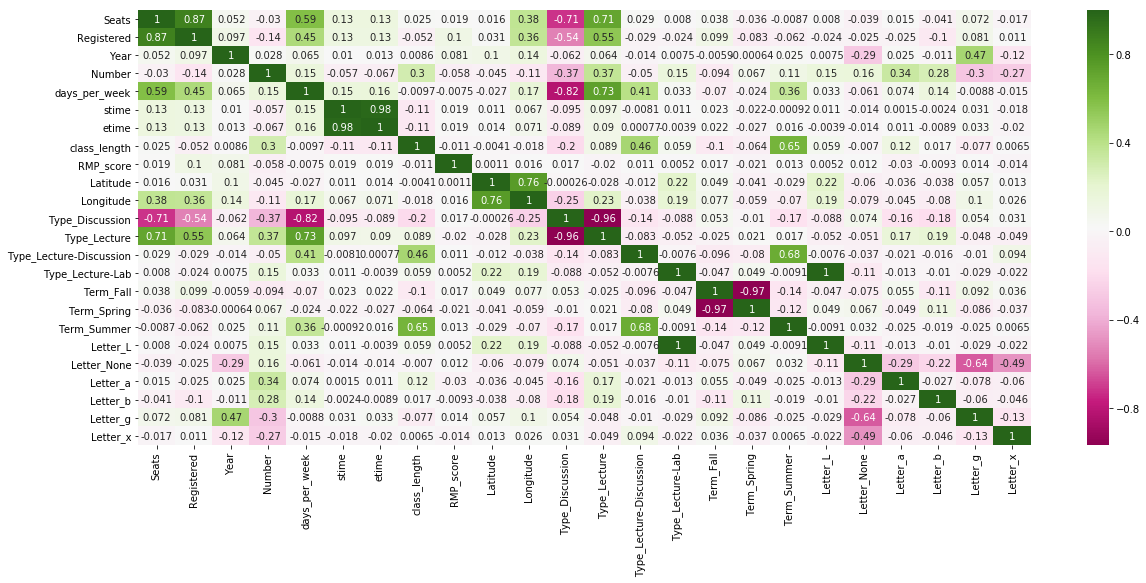

In [78]:
plt.figure(figsize = (20,8))
sns.heatmap(corr_matrix,annot=True,cmap='PiYG');

As we see above, there aren't too many features that correlate well with 'Registered'. The one that sticks out the most is 'Seats', which makes sense since there can't be more students registered for a class than the number of seats available. The type of class is also somewhat correlated, as well the days per week. The latter makes sense since discussion sections are usually twice a week while lectures are three times.

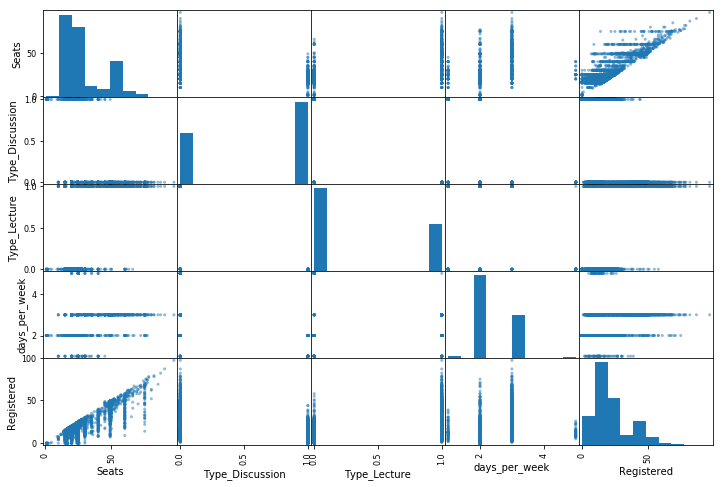

In [79]:
corr_feat = ['Seats','Type_Discussion','Type_Lecture','days_per_week','Registered']
pd.plotting.scatter_matrix(train[corr_feat],figsize=(12,8));

Since we're learning, let's see how well a linear regression would do with these features.

In [80]:
from sklearn.linear_model import LinearRegression
linreg = LinearRegression()

In [81]:
from sklearn.metrics import mean_squared_error

In [82]:
reg_train = train[['Seats','Type_Discussion','Type_Lecture','days_per_week']]
reg_target = train['Registered']

In [83]:
linreg.fit(reg_train,reg_target)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [84]:
reg_predict = linreg.predict(reg_train)
linmse = mean_squared_error(reg_target,reg_predict)
linrmse = np.sqrt(linmse)
linrmse

6.681829333665137

Since lectures will have a max enrollment of 50 students, begin almost 7 off on average doesn't seem very good. Let's also practice some cross validation.

In [88]:
from sklearn.model_selection import cross_val_score
lin_scores = cross_val_score(linreg, reg_train,reg_target,
                             scoring = 'neg_mean_squared_error',cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)

In [90]:
lin_rmse_scores.mean()

6.682856585700209

Cross validation show the model performs about the same as with a single validation set. Let's see what would happen if we trained with all of the features.

In [93]:
lin_scores_all = cross_val_score(linreg, train.drop('Registered',axis=1),train['Registered'],
                                scoring = 'neg_mean_squared_error',cv=10)
linall_rmse_scores = np.sqrt(-lin_scores_all)
linall_rmse_scores.mean()

6.424374306546397

Looks like it performs just slightly better on average, but still not very good.

Let's try a Random Forest now.

In [94]:
from sklearn.ensemble import RandomForestRegressor
forreg = RandomForestRegressor()
forreg.fit(train.drop('Registered',axis=1),train['Registered'])
for_predict = forreg.predict(train.drop('Registered',axis=1))
formse = mean_squared_error(for_predict,train['Registered'])
np.sqrt(formse)

C:\Users\zacwi\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


2.3321727757169177

Much better than the linear regression did. Now for cross validation.

In [95]:
for_score = cross_val_score(forreg, train.drop('Registered',axis=1), train['Registered'],
                           scoring = 'neg_mean_squared_error',cv=10)
for_rmse_scores = np.sqrt(-for_score)
for_rmse_scores.mean()

5.518509830444409

Well, still better than linear regression, but not as good as our first check.

Let's do a grid search to find a good combination of hyperparameters for the Random Forest since it performed better. The default number of estimators is 10 in my current version, but will be updated to 100 (see the warning above), so I opted for 10, 50, and 100 to try. Since we did a regression on 4 features at first, I chose 4 roughly spaced numbers for max features ranging from 4 to all of them (23). We also set bootstrap to False to see if building each tree with all of the data would make a difference.

In [96]:
from sklearn.model_selection import GridSearchCV
param_grid = [{'n_estimators':[10,50,100], 'max_features':[4,10,16,23]},
             {'bootstrap':[False], 'n_estimators':[10,50], 'max_features':[4,11,17]}]

In [97]:
X_train = train.drop('Registered',axis=1)
y_train = train['Registered']
forreg = RandomForestRegressor()
grid_search = GridSearchCV(forreg, param_grid, cv=5,
                          scoring='neg_mean_squared_error',
                          return_train_score=True)
grid_search.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'n_estimators': [10, 50, 100], 'max_features': [4, 10, 16, 23]}, {'bootstrap': [False], 'n_estimators': [10, 50], 'max_features': [4, 11, 17]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [98]:
grid_search.best_params_

{'max_features': 16, 'n_estimators': 50}

In [99]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=16, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=50, n_jobs=None, oob_score=False,
           random_state=None, verbose=0, warm_start=False)

Now let's check out its root mean square error.

In [104]:
results = grid_search.cv_results_
for mean_score,params in zip(results['mean_test_score'],results['params']):
    print(np.sqrt(-mean_score),params)

5.856036688146795 {'max_features': 4, 'n_estimators': 10}
5.589212786217215 {'max_features': 4, 'n_estimators': 50}
5.5536985911249355 {'max_features': 4, 'n_estimators': 100}
5.526663375302081 {'max_features': 10, 'n_estimators': 10}
5.325812781447138 {'max_features': 10, 'n_estimators': 50}
5.30262269238471 {'max_features': 10, 'n_estimators': 100}
5.495438616238282 {'max_features': 16, 'n_estimators': 10}
5.286790162662162 {'max_features': 16, 'n_estimators': 50}
5.293700283695387 {'max_features': 16, 'n_estimators': 100}
5.5400886501193405 {'max_features': 23, 'n_estimators': 10}
5.363779716282414 {'max_features': 23, 'n_estimators': 50}
5.3328896247778825 {'max_features': 23, 'n_estimators': 100}
5.821859407881359 {'bootstrap': False, 'max_features': 4, 'n_estimators': 10}
5.625328061887817 {'bootstrap': False, 'max_features': 4, 'n_estimators': 50}
5.6489070005602136 {'bootstrap': False, 'max_features': 11, 'n_estimators': 10}
5.508386798705543 {'bootstrap': False, 'max_features'

We obviously haven't gone through every hyperparameter, and our choices were rather arbitrary, but it looks like we can't really do better than an error of 5. For our present purposes, that's alright though.

In [109]:
feature_importances = grid_search.best_estimator_.feature_importances_
sorted(zip(feature_importances,X_train.columns),reverse=True)

[(0.6764466153051916, 'Seats'),
 (0.10518393276781185, 'Longitude'),
 (0.037264084808512905, 'Number'),
 (0.03682036387990824, 'Type_Lecture'),
 (0.034592966212814054, 'Year'),
 (0.029814742829785478, 'RMP_score'),
 (0.0152425164798736, 'etime'),
 (0.01419040081595107, 'Latitude'),
 (0.014147339682506413, 'stime'),
 (0.008783213216242217, 'days_per_week'),
 (0.006014400000413398, 'Type_Discussion'),
 (0.005587120160904069, 'Term_Spring'),
 (0.0051759156593594756, 'Term_Fall'),
 (0.003278994966956928, 'Letter_g'),
 (0.002338260408353077, 'Letter_None'),
 (0.002076495951146508, 'class_length'),
 (0.0010529185239600237, 'Letter_x'),
 (0.0007344040483677806, 'Letter_a'),
 (0.0003713906113110768, 'Type_Lecture-Discussion'),
 (0.00028549379375066594, 'Letter_b'),
 (0.00025938489339478267, 'Letter_L'),
 (0.00018929883297630164, 'Type_Lecture-Lab'),
 (0.00014974615050852667, 'Term_Summer')]

As expected, 'Seats' is the most important feature. Interestingly, longitude is the next most important. Perhaps we should try dropping features with less than .01 in importance. Will do this separately after using what we already have.

In [122]:
model = grid_search.best_estimator_

test = prepare_data(test)
X_test = test.drop('Registered',axis=1)
y_test = test['Registered'].copy()

In [123]:
model_predict = model.predict(X_test)
model_rmse = np.sqrt(mean_squared_error(y_test,model_predict))
model_rmse

5.406496319046871

This is not wildly off from our error after selecting the best estimator.

That is all for now! (January 23, 2020) This was a fun project, and I certainly learned a lot. I might return to this one day after more data is avilable and, more importantly, when I learn more about data analysis and data science.